# IN-DEPTH ANALYSIS - KILLED OR SERIOUSLY INJURED DATA

## MACHINE LEARNING PROCESS

The KSI dataset consists mostly of categorical data, and hence we will use the method of supervised learning to make prediction on whether a certain person will survive or not from an accident. 
The independent variable in question is 'INJURY', which we will classify as Fatal/Major or Minimal as impact in a person from an accident

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import ipywidgets
import geocoder
import geopy
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

### 1. Preprocessing

 - Dropping unnecessary columns and engineer the date columns to get hour and day of the week

In [2]:
#import the data file for KSI - Killed or Seriously Injured from the Toronto Police Service webstie
data = pd.read_csv('ksidataupdated.csv', index_col = 0)
#dropping out some columns that are not of interest 
data = data.drop(columns = ['ACCNUM','LATITUDE', 'LONGITUDE', 'ObjectId', 'ADDRESS','TRSN_CITY_VEH', 'ACCLASS', 'Neighbourhood'])
#Replacing all other injury as Non-fatal 
data['INJURY']=data.INJURY.replace(['Minor', 'Minimal', 'Unknown/Other', 'None'], 'Minimal')
data['INJURY']=data.INJURY.replace(['Fatal', 'Major'], 'Fatal/Major')
#Creating a new column for day of the week
data.index = pd.to_datetime(data.index)
data['WEEKDAY'] = data.index.dayofweek
data.columns

Index(['HOUR', 'ROAD_CLASS', 'District', 'LOCCOORD', 'TRAFFCTL', 'VISIBILITY',
       'LIGHT', 'RDSFCOND', 'IMPACTYPE', 'INVTYPE', 'INVAGE', 'INJURY',
       'INITDIR', 'VEHTYPE', 'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE',
       'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND', 'PEDESTRIAN',
       'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'EMERG_VEH',
       'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY',
       'Hood_ID', 'TRSN_CITY_', 'WEEKDAY'],
      dtype='object')

 - Checking for correlation between variables

The majority of our data includes categorical variables so we will perform Chi-square to determine independence.

In [4]:
# Split into features and fatality
X = data.loc[:, data.columns != "INJURY"]
y = data["INJURY"]

print("The dataset contains {} rows and {} columns. \n".format(data.shape[0], data.shape[1]))
print("Number of unique values for each category: \n")
print(data.nunique().sort_values(ascending=False))
print()

class_counts = data["INJURY"].value_counts()

print("Percentage of each class:")
print(class_counts/data.shape[0] * 100)
data.head()

The dataset contains 14457 rows and 38 columns. 

Number of unique values for each category: 

Hood_ID       140
VEHTYPE        27
HOUR           24
CYCLISTYPE     23
INVAGE         21
INVTYPE        17
PEDTYPE        16
MANOEUVER      15
PEDACT         15
DRIVACT        13
TRAFFCTL       12
IMPACTYPE      11
CYCACT         11
DRIVCOND        9
CYCCOND         9
PEDCOND         9
LIGHT           9
RDSFCOND        9
VISIBILITY      8
ROAD_CLASS      8
LOCCOORD        8
WEEKDAY         7
INITDIR         5
District        4
ALCOHOL         2
DISABILITY      2
EMERG_VEH       2
INJURY          2
REDLIGHT        2
TRUCK           2
SPEEDING        2
TRSN_CITY_      2
PASSENGER       2
PEDESTRIAN      2
CYCLIST         2
AUTOMOBILE      2
MOTORCYCLE      2
AG_DRIV         2
dtype: int64

Percentage of each class:
Minimal        57.418552
Fatal/Major    42.581448
Name: INJURY, dtype: float64


,HOUR,ROAD_CLASS,District,LOCCOORD,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,IMPACTYPE,INVTYPE,...,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Hood_ID,TRSN_CITY_,WEEKDAY
2006-01-01 02:36:00,2,Major Arterial,Toronto and East York,Intersection,No Control,Clear,Dark,Wet,Approaching,Passenger,...,No,Yes,Yes,Yes,No,Yes,No,60,No,6
2006-01-01 02:36:00,2,Major Arterial,Toronto and East York,Intersection,No Control,Clear,Dark,Wet,Approaching,Passenger,...,No,Yes,Yes,Yes,No,Yes,No,60,No,6
2006-01-01 02:36:00,2,Major Arterial,Toronto and East York,Intersection,No Control,Clear,Dark,Wet,Approaching,Driver,...,No,Yes,Yes,Yes,No,Yes,No,60,No,6
2006-01-01 02:36:00,2,Major Arterial,Toronto and East York,Intersection,No Control,Clear,Dark,Wet,Approaching,Passenger,...,No,Yes,Yes,Yes,No,Yes,No,60,No,6
2006-01-01 02:36:00,2,Major Arterial,Toronto and East York,Intersection,No Control,Clear,Dark,Wet,Approaching,Passenger,...,No,Yes,Yes,Yes,No,Yes,No,60,No,6


Our dataset looks quite balanced in terms of the two classes: Minimal and Fatal/Major with slightly more number of people falling into the Minimal Injury (57.4% versus 42.6%)

Our hypothesis for testing covariance is as follows:
<p>H0:  A and B are independent

H1: A and B are dependent</p>

In [5]:
# Define alpha
alpha = 0.05

for col in X.columns.values:

    a1, a2 = data[col], data["INJURY"]

    pairobserved = pd.crosstab(a1, a2) 
    chi2, p, dof, expected = chi2_contingency(pairobserved.values)

    if p < alpha:
        # Reject null hypothesis
        print("{} is independent. (p = {})".format(col, p))
    else:
        # Accept null hypothesis
        print("{} is NOT independent. (p = {})".format(col, p))

HOUR is NOT independent. (p = 0.9178746069916593)
ROAD_CLASS is independent. (p = 0.0001445261746628117)
District is NOT independent. (p = 0.5733056680700581)
LOCCOORD is NOT independent. (p = 0.7223388221401688)
TRAFFCTL is NOT independent. (p = 0.22644389781511207)
VISIBILITY is NOT independent. (p = 0.5200474640775424)
LIGHT is NOT independent. (p = 0.9098531833572134)
RDSFCOND is NOT independent. (p = 0.6998387235800497)
IMPACTYPE is independent. (p = 2.216142815781824e-42)
INVTYPE is independent. (p = 0.0)
INVAGE is independent. (p = 5.2190970178964424e-163)
INITDIR is independent. (p = 0.019809392636376665)
VEHTYPE is independent. (p = 0.0)
MANOEUVER is independent. (p = 0.0)
DRIVACT is independent. (p = 0.0)
DRIVCOND is independent. (p = 0.0)
PEDTYPE is independent. (p = 0.0)
PEDACT is independent. (p = 0.0)
PEDCOND is independent. (p = 0.0)
CYCLISTYPE is independent. (p = 6.352333500618271e-158)
CYCACT is independent. (p = 7.462043078855503e-149)
CYCCOND is independent. (p = 8.

From the above we can see the following variables: HOUR, District, LOCCOORD, TRAFFCTL, VISIBILITY, LIGHT, RDSFCOND, EMERG_VEH, SPEEDING, ALCOHOL, DISABILITY, Hood_ID, TRSN_CITY_, WEEKDAY show high P-value and we will drop them from the models. In fact, this seems quite intuitive that speeding/ alcohol makes an accident fatal/major. 

In [6]:
data = data.drop(columns=['HOUR', 'District', 'LOCCOORD', 'TRAFFCTL','VISIBILITY', 'LIGHT', 'RDSFCOND', 'EMERG_VEH', 'SPEEDING', 'ALCOHOL', 'DISABILITY', 'Hood_ID', 'TRSN_CITY_', 'WEEKDAY'])
X = X.drop(['HOUR', 'District', 'LOCCOORD', 'TRAFFCTL','VISIBILITY', 'LIGHT', 'RDSFCOND', 'EMERG_VEH', 'SPEEDING', 'ALCOHOL', 'DISABILITY', 'Hood_ID', 'TRSN_CITY_', 'WEEKDAY'], axis=1)

Another interesting way to determine relationship between data is by looking at the association heatmap. Cramer's V is a measure of association between nominal variables. The value is between 0 and 1, with a number closer to 1 denoting a strong association. It is based on the chi squared statistic.

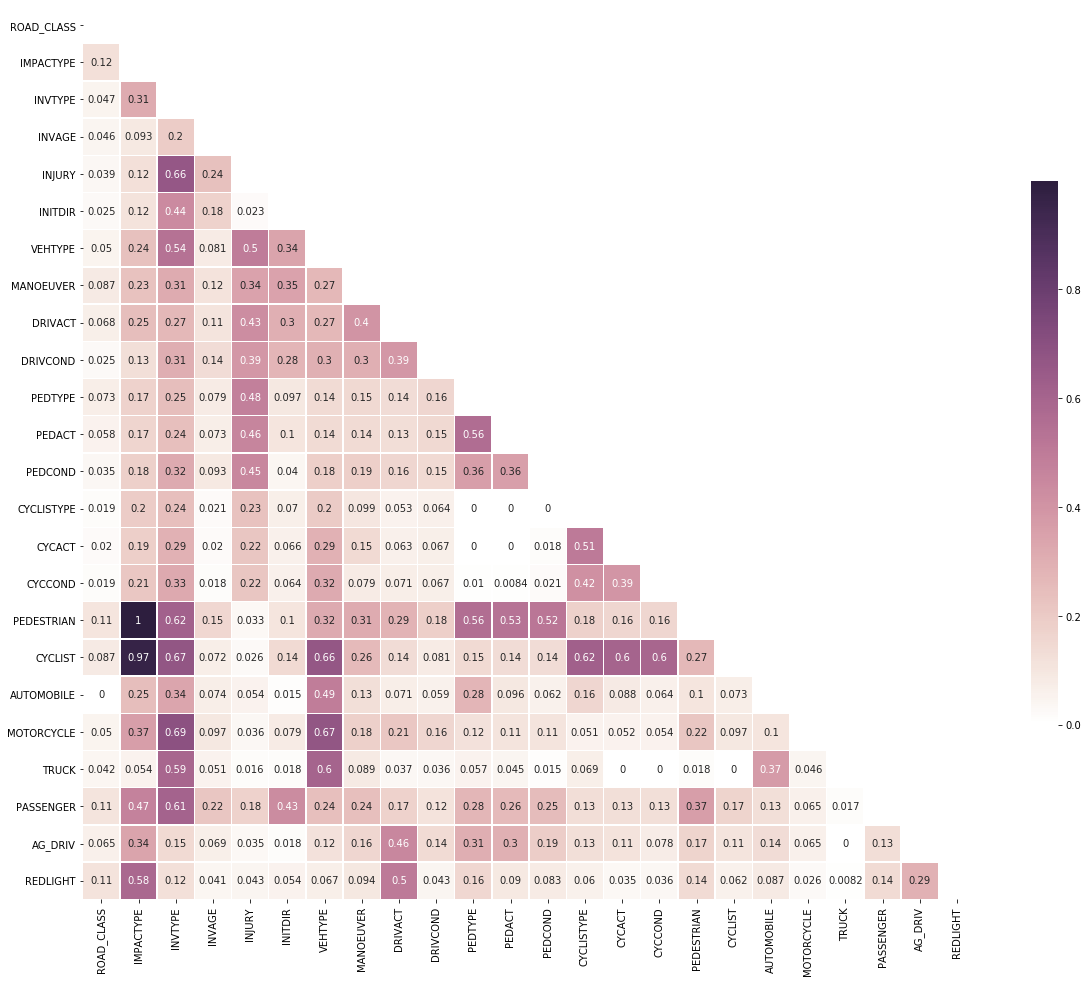

In [7]:
import itertools

def cramers_corrected_stat(confusion_matrix): 
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cols = list(data.columns.values)
corrM = np.zeros((len(cols),len(cols)))

# Calculate correlations of every combination of variables
for col1, col2 in itertools.combinations(cols, 2):

    A, B = data[col1], data[col2]
    
    idx1, idx2 = cols.index(col1), cols.index(col2)
    dfObserved = pd.crosstab(A,B) 
    corrM[idx1, idx2] = cramers_corrected_stat(dfObserved.values)
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)

# Mask to get lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

# Draw the heatmap with the mask 
fig = plt.figure(figsize=(20, 20))

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

There is a strong association between Pedestrian and impact type and cyclist and impact type. It seems intuitive since PEDESTRIAN and CYCLIST are dummy variables and whether an accident involves them or not will classify the type of impact it is. For this reason, we will also drop IMPACTYPE from the columns.

In [8]:
data.drop('IMPACTYPE', axis=1, inplace=True)
X=X.drop('IMPACTYPE', axis=1)

 - Converting data into numerical values

Machine learning requires that the input and the output variables being numerical values. As a result, the first step in getting the data ready is through making sure all the variables are in numerical form.
<p>For the X value, we will use the method called OneHotEncoder to transform the data into different columns since all the data we have are unordered categorical variables, we do not want our model to run as if the numbered ordering matters. OneHotEncoder will split data in the number of columns corresponding to the number of options for each categorical data.</p>

In [18]:
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
# Transform all the X's categorical values into numerical values
onehotencoder = OneHotEncoder()
X_2 = onehotencoder.fit_transform(X).toarray()
# y= column 'INJURY' is of binary value and hence we will convert it into binary label
lb = LabelBinarizer()
y_2 = lb.fit_transform(y)

X_2

array([[0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.]])

As we notice by looking at X_2, we can see that all the data now includes dummy variables. 

### Building machine learning model

Now that we have our data ready, we will build a model to predict whether a person will suffer from a major/fatal injury or a minimal injury impact by running our data above. 
<p>The classification problem is a binary problem and hence decision tree, which will split data in different groups seem appropriate.</p>

In [29]:
from sklearn.model_selection import cross_validate, StratifiedKFold, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier


# Define our data splitting
split = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
tree = DecisionTreeClassifier()
score = cross_validate(tree, X_2, y_2.ravel(), cv=split)
print("Test score:                  {}".format(scores["test_score"]))
# Print average across K tests
print("Average test score:       any   {} (+/- {})".format(scores["test_score"].mean(), scores["test_score"].std() * 2))

Test score:                  [0.81507086 0.81044621 0.81528883 0.82601176 0.81840194]
Average test score:       any   0.8170439196318646 (+/- 0.010306092754609726)


The decision tree model gives us a pretty good scoring of approximately 81.7% accuracy of predicting whether a person would suffer a Fatal/Major injury or not from the accident.